### Importing Resources

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### External Data Set Sources
(Convert datasets to specified formats and use specified name)

- 'rdl0103.xslx': https://www.gov.uk/government/statistical-data-sets/road-length-statistics-rdl (RDL0103: Road length (miles) by road type in Great Britain)
- 'charging point data.xlsx': https://www.gov.uk/government/collections/electric-vehicle-charging-infrastructure-statistics (Electric vehicle charging device statistics: April 2022)
- 'veh0170.xlsx': https://www.gov.uk/government/statistical-data-sets/all-vehicles-veh01 (VEH0170: Ultra low emission vehicles registered for the first time: United Kingdom)
- 'veh0202.xlsx': https://www.gov.uk/government/statistical-data-sets/veh02-licensed-cars (VEH0202: Licensed cars by keepership (private and company): Great Britain and United Kingdom)


### Importing and Cleaning Data

In [2]:
data = 'dft_traffic_counts_aadf.csv'
dataframe = pd.read_csv(data)
df = dataframe.copy()
df.drop(columns=['id',
                'local_authority_id',
                'road_name',
                'start_junction_road_name',
                'end_junction_road_name',
                'easting',
                'northing',
                'latitude',
                'longitude',
                'link_length_km',
                'estimation_method_detailed',
                'sequence',
                'ramp',
                'pedal_cycles',
                'hgvs_2_rigid_axle',
                'hgvs_3_rigid_axle',
                'hgvs_4_or_more_rigid_axle',
                'hgvs_3_or_4_articulated_axle',
                'hgvs_5_articulated_axle',
                'hgvs_6_articulated_axle'
                ], inplace=True)

df.sort_values(by=['count_point_id', 'year'], inplace=True)

rl_df = pd.read_excel('rdl0103.xlsx').dropna(how='any')
rl_df = rl_df.rename(columns=rl_df.iloc[0]).drop(rl_df.index[0])
rl_df['Year'] = rl_df['Year'].astype(str).str.extract('(\d+)', expand=False).astype(int)
rl_df = rl_df[rl_df['Year'].isin(range(2000,2021))][['Year', "'B' road", "'C' and 'U' roads"]]

annual_mileage_est = 10**11
minor_changes = [1]

B_roads = rl_df["'B' road"].values[:]
CU_roads = rl_df["'C' and 'U' roads"].values[:]

for i in range(20):
    minor_changes.append((B_roads[i+1] + CU_roads[i+1])/(B_roads[i] + CU_roads[i]))
    
rl_df['minor_changes'] = minor_changes

df.dropna(subset=['link_length_miles'], inplace=True)

annual_mileages = df[['two_wheeled_motor_vehicles',
    'cars_and_taxis',
    'buses_and_coaches',
    'lgvs',
    'all_hgvs',
    'all_motor_vehicles'
   ]].multiply(df['link_length_miles']*365, axis='index')

df_vehicle_mileage = pd.concat([df.copy()[['count_point_id', 'year', 'region_id', 'road_category', 'link_length_miles']], annual_mileages], 
                       axis=1)

df_vehicle_mileage = df_vehicle_mileage.groupby(['year', 'region_id'])[['all_motor_vehicles',
                                           'two_wheeled_motor_vehicles',
                                           'cars_and_taxis',
                                           'buses_and_coaches',
                                           'lgvs',
                                           'all_hgvs']].sum().reset_index()

df_vehicle_mileage = df_vehicle_mileage.rename(columns={'two_wheeled_motor_vehicles': 'Two-Wheeled Motor Vehicles',
                                   'cars_and_taxis': 'Cars/Taxis',
                                   'buses_and_coaches': 'Buses/Coaches',
                                   'lgvs': 'LGVs',
                                   'all_hgvs': 'HGVs',
                                   'all_motor_vehicles': 'All Motor Vehicles'})

df_vehicle_mileage = pd.melt(df_vehicle_mileage, id_vars=['year', 'region_id'], value_vars=['Two-Wheeled Motor Vehicles',
                                           'Cars/Taxis',
                                           'Buses/Coaches',
                                           'LGVs',
                                           'HGVs',
                                           'All Motor Vehicles'])

df_vehicle_mileage = df_vehicle_mileage.rename(columns={'variable': 'vehicle_type', 'value': 'annual_mileage'})

df_vehicle_mileage = (df_vehicle_mileage.groupby(['year', 'region_id', 'vehicle_type'])['annual_mileage']
              .sum()
              .to_frame())

df_vehicle_mileage['annual_mileage (billions)'] = df_vehicle_mileage['annual_mileage'].apply(lambda x: x/10**9)


### Grouping Annual Mileage (Major Roads) by Region and Vehicle Type
- Split data into groups of annual mileages of each vehicle type per region for every year from 2000 to 2020
- Introduce appropriate column to round large numbers

In [3]:
df_vehicle_mileage

annual_mileage  \
year region_id vehicle_type                                 
2000 1         All Motor Vehicles            1.723785e+10   
               Buses/Coaches                 1.366148e+08   
               Cars/Taxis                    1.384913e+10   
               HGVs                          1.288888e+09   
               LGVs                          1.801174e+09   
...                                                   ...   
2020 11        Buses/Coaches                 2.972321e+07   
               Cars/Taxis                    4.610665e+09   
               HGVs                          3.608797e+08   
               LGVs                          9.748828e+08   
               Two-Wheeled Motor Vehicles    2.747023e+07   

                                           annual_mileage (billions)  
year region_id vehicle_type                                           
2000 1         All Motor Vehicles                          17.237847  
               Buses/Coaches                                0.136615  
               Cars/Taxis                                  13.849128  
               HGVs                                         1.288888  
               LGVs                                         1.801174  
...                                                              ...  
2020 11        Buses/Coaches                                0.029723  
               Cars/Taxis                                   4.610665  
               HGVs                                         0.360880  
               LGVs                                         0.974883  
               Two-Wheeled Motor Vehicles                   0.027470  

[1386 rows x 2 columns]

### Summary Statistics of Annual Mileages of Vehicle Types per Region

In [4]:
vehicle_types = ['All Motor Vehicles', 'Buses/Coaches', 'Cars/Taxis', 'HGVs', 'LGVs',
                 'Two-Wheeled Motor Vehicles']

for v_type in vehicle_types:
    stat = df_vehicle_mileage[df_vehicle_mileage.index.get_level_values('vehicle_type').str.contains(str(v_type))] 
    print(f'\033[1m{v_type}\033[0m')
    print(round(stat.describe().iloc[np.r_[1:4, -1]], 2))
    print('\n')

All Motor Vehicles
      annual_mileage  annual_mileage (billions)
mean    1.819697e+10                      18.20
std     7.207420e+09                       7.21
min     6.003577e+09                       6.00
max     3.790387e+10                      37.90


Buses/Coaches
      annual_mileage  annual_mileage (billions)
mean    1.374705e+08                       0.14
std     6.079599e+07                       0.06
min     2.972321e+07                       0.03
max     2.788493e+08                       0.28


Cars/Taxis
      annual_mileage  annual_mileage (billions)
mean    1.415483e+10                      14.15
std     5.722837e+09                       5.72
min     4.610665e+09                       4.61
max     2.952983e+10                      29.53


HGVs
      annual_mileage  annual_mileage (billions)
mean    1.378529e+09                       1.38
std     5.852016e+08                       0.59
min     3.608797e+08                       0.36
max     2.358426e+09             

### Visualising Trends in Data
- Producing various relevant plots to portray view annual mileages across 2000 to 2020
- Analysis by region and vehicle typing
- Plot to display regional contributions to annual mileage
- Plot to display annual mileage of different vehicle types
- Spatial Plot comparing distribution of Annual Mileage across the UK from 2000, 2010 and 2020
- Comparing results to those found in: https://roadtraffic.dft.gov.uk/summary

#### Annual Mileage of Motor Vehicles per Region from 2000 to 2020

In [5]:
m = df_vehicle_mileage.copy()
vm = m[m.index.get_level_values('vehicle_type') != 'All Motor Vehicles']


years = list(set(vm.index.get_level_values('year')))
regions = list(set(vm.index.get_level_values('region_id')))

lst = []

for year in years:
    for region in regions:
        value = vm[(vm.index.get_level_values('year') == year) & (vm.index.get_level_values('region_id') == region)]['annual_mileage (billions)'].sum()
        lst.append((year, region, value))

year, region, annual_mileage = zip(*lst)

year = pd.Series(year)
region = pd.Series(region)
annual_mileage = pd.Series(annual_mileage)

rm = pd.concat([year, region, annual_mileage], axis=1).rename(columns={0: 'year', 1: 'region_id', 2: 'annual_mileage (billions)'})
rm = rm.groupby(['year', 'region_id'])['annual_mileage (billions)'].sum().to_frame().reset_index()

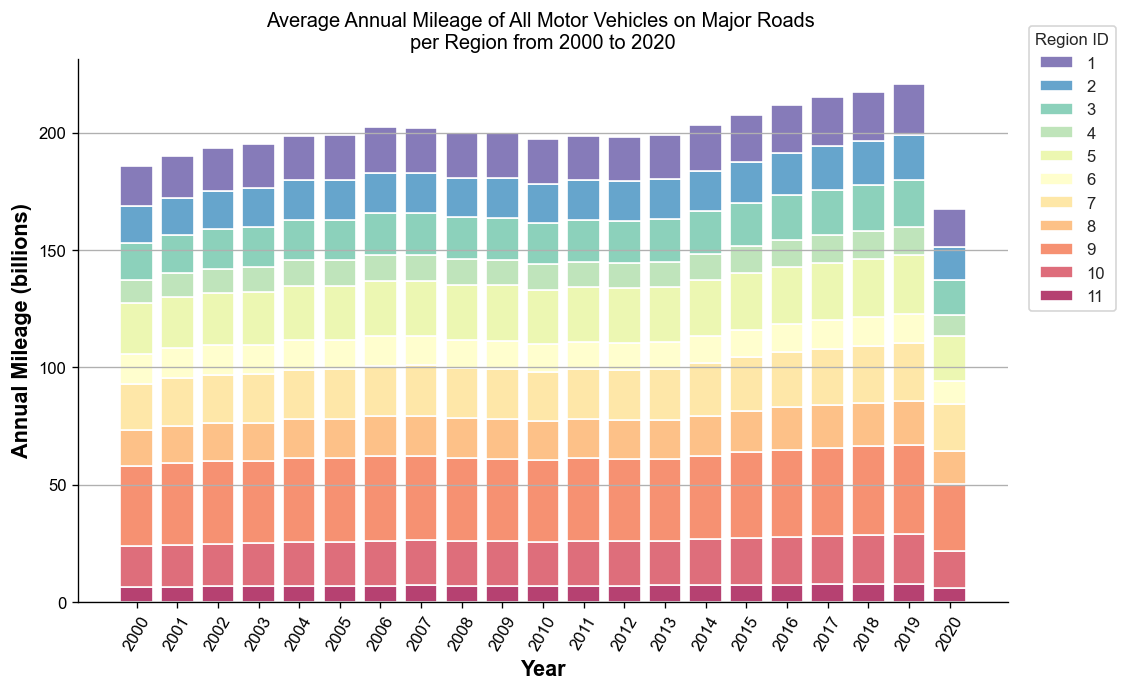

In [6]:
fig, ax = plt.subplots(figsize=(10,6), dpi=120)

sns.set_style("whitegrid")
rm_plot = sns.histplot(rm,
            x='year',
            weights='annual_mileage (billions)',
            hue='region_id',
            multiple='stack',
            edgecolor='white',
            shrink=0.8,
            bins=21,
            palette='Spectral_r'
            )

sns.move_legend(rm_plot, bbox_to_anchor=(1.125, 1.075), loc='upper right', title='Region ID')
mids = [rect.get_x() + rect.get_width() / 2 for rect in rm_plot.patches]

ax.grid(False)
ax.grid(axis='y')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.xlabel('Year', fontweight='bold', fontsize=13)
plt.ylabel('Annual Mileage (billions)', fontweight='bold', fontsize=13)
plt.xticks(mids[:21], labels=list(range(2000,2021)), rotation=60)
plt.title('Average Annual Mileage of All Motor Vehicles on Major Roads \nper Region from 2000 to 2020')
plt.show()

#### Annual Mileage of Vehicle Types on Major Roads from 2000 to 2020

In [7]:
m = df_vehicle_mileage.copy()
vtm = m.reset_index().groupby(['year', 'vehicle_type'])['annual_mileage (billions)'].sum().to_frame()
vtm = vtm.reset_index()

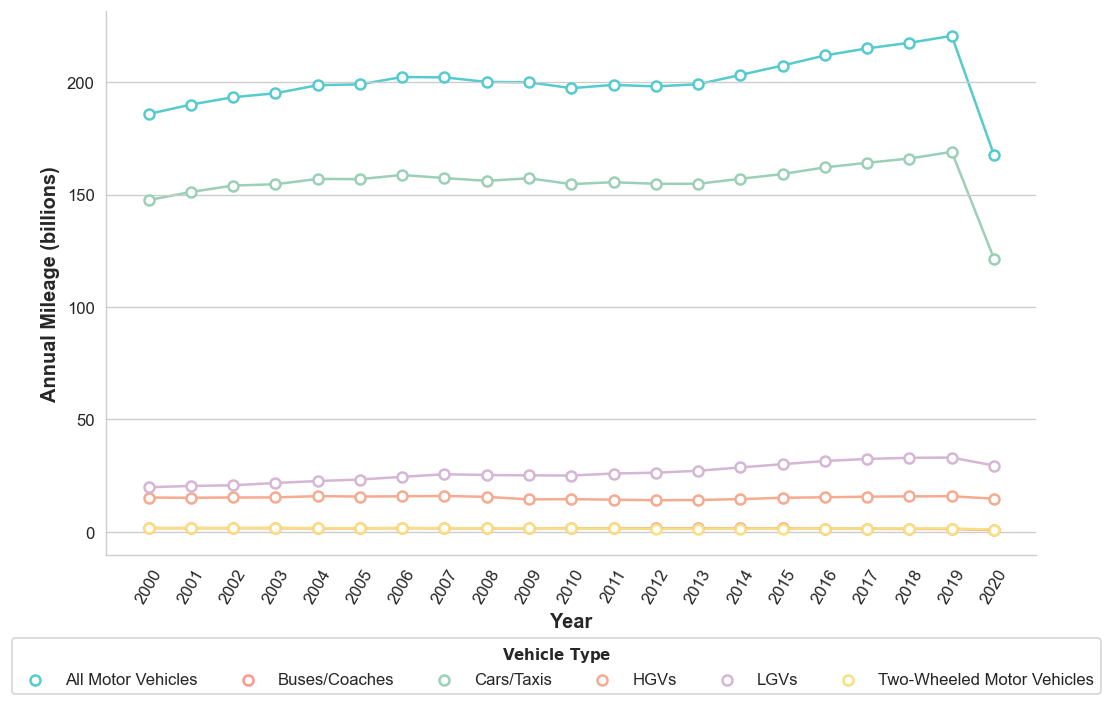

In [8]:
sns.set_style('whitegrid')

colors = {'Cars/Taxis': '#9bd0b7',
          'All Motor Vehicles': '#55cbcd',
          'HGVs': '#f6aa90',
          'LGVs': '#d5b6d5',
          'Buses/Coaches': '#ff968a',
          'Two-Wheeled Motor Vehicles': '#f8df81'}

fig, ax = plt.subplots(figsize=(10,6), dpi=120)

for vehicle_type in vehicle_types:
    ax.plot(vtm[vtm['vehicle_type'] == vehicle_type]['year'], 
                vtm[vtm['vehicle_type'] == vehicle_type]['annual_mileage (billions)'],
                color=colors[vehicle_type],
                linewidth=1.5,
                zorder=0)
    ax.scatter(vtm[vtm['vehicle_type'] == vehicle_type]['year'], 
                vtm[vtm['vehicle_type'] == vehicle_type]['annual_mileage (billions)'],
                color=colors[vehicle_type],
                linewidth=1.5,
                facecolors='white',
                zorder=1,
                label=vehicle_type)
ax.grid(False)
ax.grid(axis='y')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xticks(ticks=list(range(2000,2021)))
ax.set_xticklabels(labels=[str(x) for x in list(range(2000,2021))], rotation=60)
ax.set_xlabel('Year', fontweight='bold', fontsize=12)
ax.set_ylabel('Annual Mileage (billions)', fontweight='bold', fontsize=12)
fig.legend(bbox_to_anchor=(0.5, -0.08), title='$\\bf{Vehicle\ Type}$',
           title_fontsize=9, loc='lower center', ncol=6)
plt.show()

### Including Estimated Minor Road Data

#### Annual Mileage of Motor Vehicles per Region from 2000 to 2020

In [9]:
df_rw = df_vehicle_mileage.groupby(['year', 'region_id']).sum().reset_index()

weight = []

for year in years:
    for region in regions:
        weight.append(dataframe[(dataframe['road_type'] == 'Minor') & (dataframe['year'] == year) & (dataframe['region_id'] == region)]['region_id'].sum()/dataframe[(dataframe['road_type'] == 'Minor') & (dataframe['year'] == year)]['region_id'].sum())

df_rw['weight'] = weight

for year in years:
    df_rw.loc[df_rw['year'] == year, 
                  'minor_changes'] = rl_df[rl_df['Year'] == year]['minor_changes'].values[0]

df_rw['minor_est'] = annual_mileage_est*df_rw['weight']

for i in range(len(years)-1):
    for region in regions:
        df_rw.loc[(df_rw['year'] == years[i+1]) & (df_rw['region_id'] == region), 
            'minor_est'] = df_rw[df_rw['year'] == years[i]]['minor_est'].sum()*df_rw[(df_rw['year'] == years[i+1]) & 
                    (df_rw['region_id'] == region)]['weight'].values[0]*df_rw[(df_rw['year'] == years[i+1])]['minor_changes'].values[0]

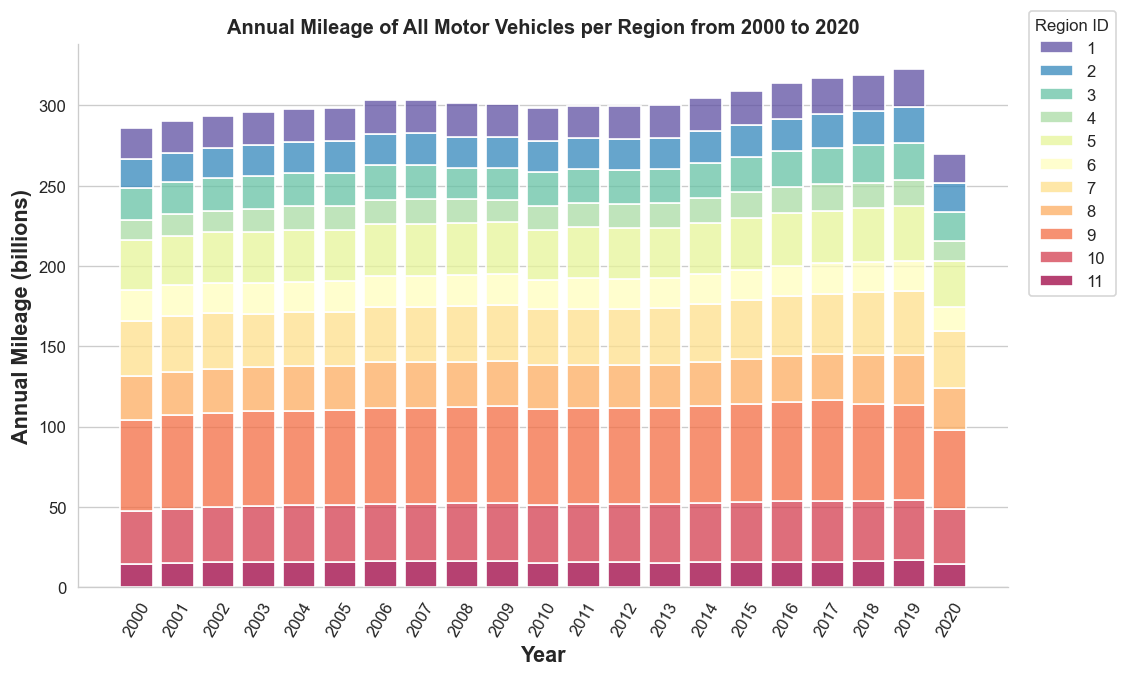

In [10]:
rm_comb = rm.copy()
rm_comb['annual_mileage (billions)'] += (df_rw['minor_est']/10**9)

fig, ax = plt.subplots(figsize=(10,6), dpi=120)

sns.set_style("whitegrid")
rm_plot = sns.histplot(rm_comb,
            x='year',
            weights='annual_mileage (billions)',
            hue='region_id',
            multiple='stack',
            edgecolor='white',
            shrink=0.8,
            bins=21,
            palette='Spectral_r'
            )

sns.move_legend(rm_plot, bbox_to_anchor=(1.125, 1.075), loc='upper right', title='Region ID')
mids = [rect.get_x() + rect.get_width() / 2 for rect in rm_plot.patches]

ax.grid(False)
ax.grid(axis='y')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.xlabel('Year', fontweight='bold', fontsize=13)
plt.ylabel('Annual Mileage (billions)', fontweight='bold', fontsize=13)
plt.xticks(mids[:21], labels=list(range(2000,2021)), rotation=60)
plt.title('Annual Mileage of All Motor Vehicles per Region from 2000 to 2020',
          fontweight='bold', fontsize=12)
plt.show()

#### Annual Mileage of Motor Vehicles per Vehicle Type from 2000 to 2020

In [11]:
df_vw = df_vehicle_mileage.groupby(['year', 'vehicle_type']).sum().reset_index()
v_match = {'All Motor Vehicles': 'all_motor_vehicles',
           'Cars/Taxis': 'cars_and_taxis',
           'Buses/Coaches': 'buses_and_coaches',
           'LGVs': 'lgvs',
           'HGVs': 'all_hgvs',
           'Two-Wheeled Motor Vehicles': 'two_wheeled_motor_vehicles'
           }

weight = []

for year in years:
    for v_type in vehicle_types:
        weight.append(dataframe[(dataframe['road_type'] == 'Minor') & (dataframe['year'] == year)][v_match[v_type]].sum()/dataframe[(dataframe['road_type'] == 'Minor') & (dataframe['year'] == year)]['all_motor_vehicles'].sum())

df_vw['weight'] = weight

for year in years:
    df_vw.loc[df_vw['year'] == year, 
                  'minor_changes'] = rl_df[rl_df['Year'] == year]['minor_changes'].values[0]

df_vw['minor_est'] = annual_mileage_est*df_vw['weight']

for i in range(len(years)-1):
    for v_type in vehicle_types:
        df_vw.loc[(df_vw['year'] == years[i+1]) & (df_vw['vehicle_type'] == v_type), 
            'minor_est'] = df_vw[(df_vw['year'] == years[i]) & 
                (df_vw['vehicle_type'] == 'All Motor Vehicles')]['minor_est'].values[0]*df_vw[(df_vw['year'] == years[i+1]) & 
                    (df_vw['vehicle_type'] == v_type)]['weight'].values[0]*df_vw[(df_vw['year'] == years[i+1])]['minor_changes'].values[0]

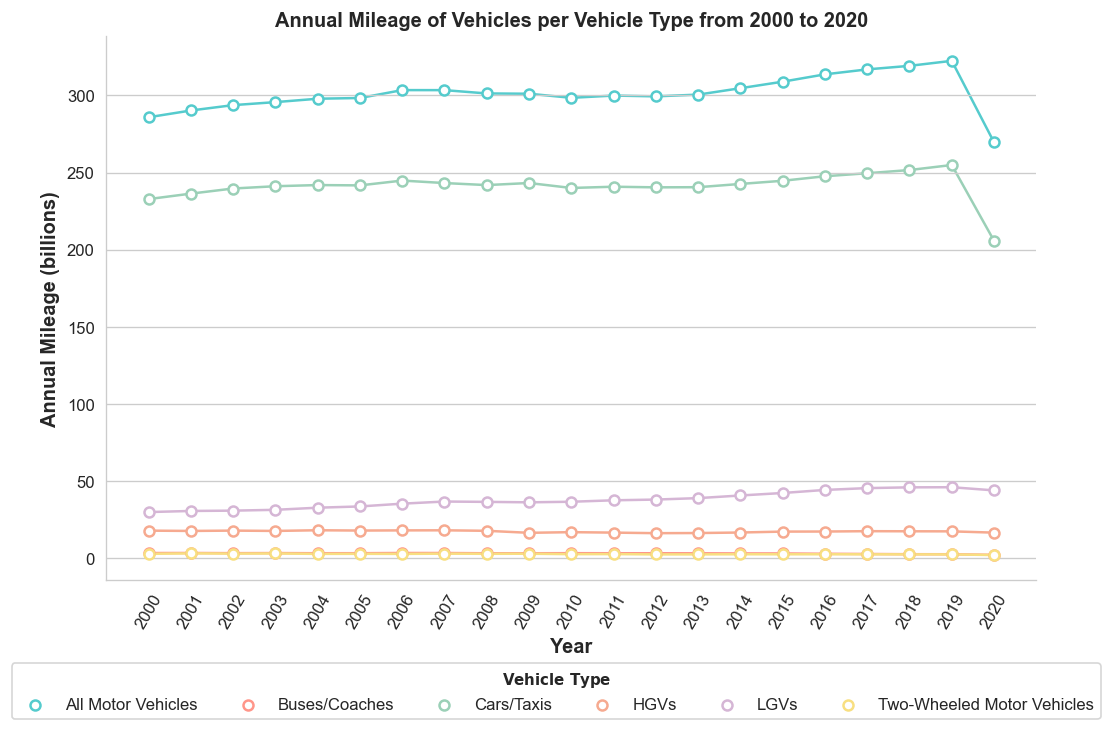

In [12]:
vtm = m.reset_index().groupby(['year', 'vehicle_type'])['annual_mileage (billions)'].sum().to_frame()
vtm = vtm.reset_index()
vtm['annual_mileage (billions)'] += (df_vw['minor_est']/10**9)

fig, ax = plt.subplots(figsize=(10,6), dpi=120)

for vehicle_type in vehicle_types:
    ax.plot(vtm[vtm['vehicle_type'] == vehicle_type]['year'], 
                vtm[vtm['vehicle_type'] == vehicle_type]['annual_mileage (billions)'],
                color=colors[vehicle_type],
                linewidth=1.5,
                zorder=0)
    ax.scatter(vtm[vtm['vehicle_type'] == vehicle_type]['year'], 
                vtm[vtm['vehicle_type'] == vehicle_type]['annual_mileage (billions)'],
                color=colors[vehicle_type],
                linewidth=1.5,
                facecolors='white',
                zorder=1,
                label=vehicle_type)
ax.grid(False)
ax.grid(axis='y')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xticks(ticks=list(range(2000,2021)))
ax.set_xticklabels(labels=[str(x) for x in list(range(2000,2021))], rotation=60)

ax.set_title('Annual Mileage of Vehicles per Vehicle Type from 2000 to 2020',
          fontweight='bold', fontsize=12)
ax.set_xlabel('Year', fontweight='bold', fontsize=12)
ax.set_ylabel('Annual Mileage (billions)', fontweight='bold', fontsize=12)
fig.legend(bbox_to_anchor=(0.5, -0.08), title='$\\bf{Vehicle\ Type}$',
           title_fontsize=9, loc='lower center', ncol=6)
plt.show()

### Insights to the Data

It is evident that annual mileage has gradually increased since 2000 despite the huge fall in 2020. This is predominantly due to UK lockdown measures established to minimise the spread of COVID-19.

### Estimating Future Annual Mileage Using Least-Squares Regression

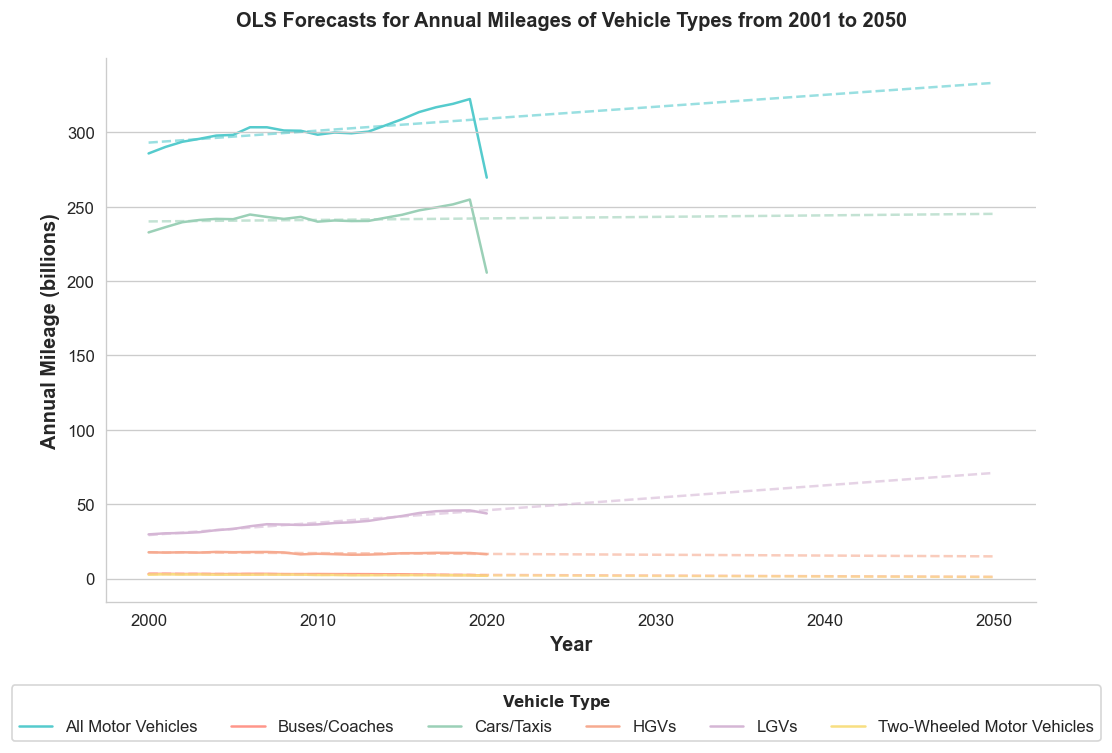

In [13]:
fig, ax = plt.subplots(figsize=(10,6), dpi=120)

for vehicle_type in vehicle_types:
    ax.plot(vtm[vtm['vehicle_type'] == vehicle_type]['year'], 
                vtm[vtm['vehicle_type'] == vehicle_type]['annual_mileage (billions)'],
                color=colors[vehicle_type],
                linewidth=1.5,
                zorder=0,
                label=vehicle_type)

    m, b = np.polyfit(vtm[vtm['vehicle_type'] == vehicle_type]['year'],
                      vtm[vtm['vehicle_type'] == vehicle_type]['annual_mileage (billions)'], 1)
    ax.plot(list(range(2000, 2051)), 
            m*pd.Series((list(range(2000, 2051))))+b, 
            color=colors[vehicle_type],
            linestyle='--',
            alpha=0.6,
            zorder=1)
    
ax.grid(False)
ax.grid(axis='y')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#ax.set_xticks(ticks=list(range(2000,2051)))
#ax.set_xticklabels(labels=[str(x) for x in list(range(2000,2051))], rotation=90)
ax.set_xlabel('Year', fontweight='bold', fontsize=12)
ax.set_ylabel('Annual Mileage (billions)', fontweight='bold', fontsize=12)
fig.legend(bbox_to_anchor=(0.5, -0.08), title='$\\bf{Vehicle\ Type}$',
           title_fontsize=9, loc='lower center', ncol=6)
ax.set_title('OLS Forecasts for Annual Mileages of Vehicle Types from 2001 to 2050\n',
         fontweight='bold', fontsize=12)
plt.show()

### Estimating Future Annual Mileage Using ARIMA

In [14]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import warnings

In [15]:
series = vtm[vtm['vehicle_type'] == 'All Motor Vehicles'][['year','annual_mileage (billions)']].set_index('year')
series.index = pd.to_datetime(series.index, format='%Y')

Using 'auto_arima' to determine optimal parameters for P, D and Q that minimise AIC

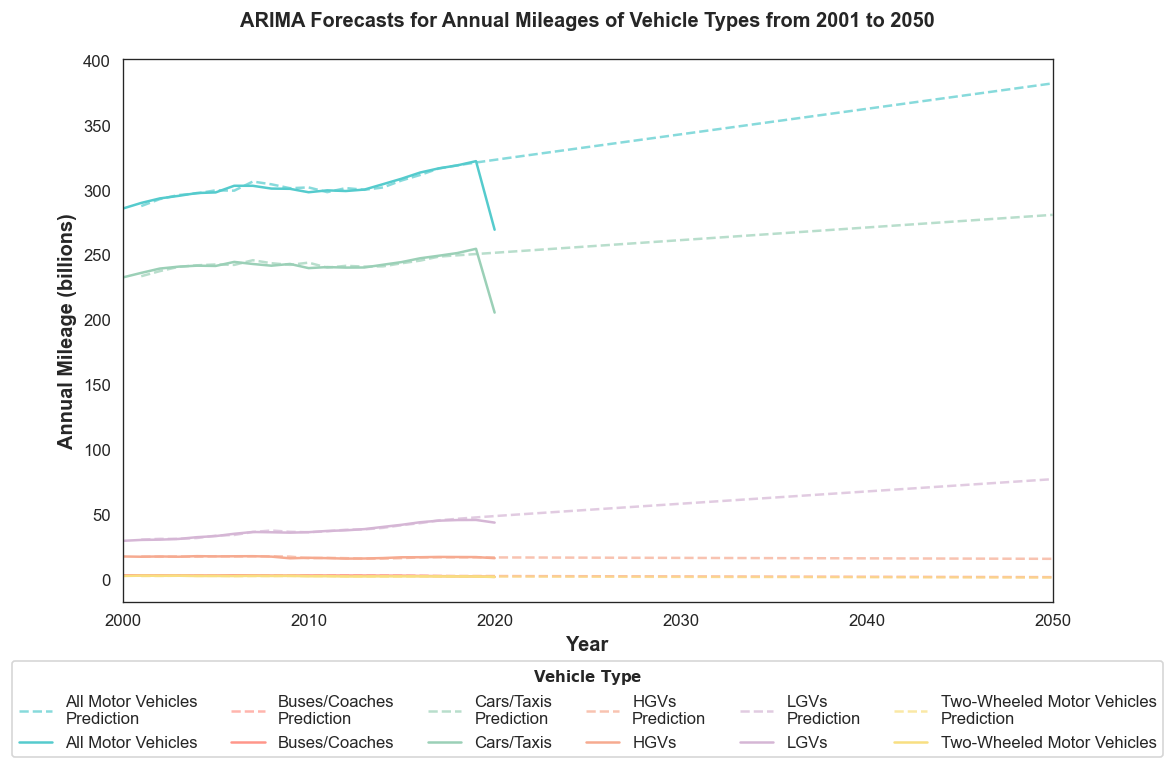

In [16]:
warnings.filterwarnings("ignore")
plt.figure(figsize=(10, 6), dpi=120)
sns.set_style('white')

for v_type in vehicle_types:
    series = vtm[vtm['vehicle_type'] == v_type][['year','annual_mileage (billions)']].set_index('year')
    series.index = pd.to_datetime(series.index, format='%Y')
    
    model=ARIMA(series['annual_mileage (billions)'][:17], order=(1,1,0), freq=None)
    model=model.fit(disp=0)
    
    pred=model.predict(start=1,end=50,typ='levels').rename(f'{v_type}\nPrediction')
    pred.plot(legend=True, color=colors[v_type], linestyle='--', alpha=0.7)
    series['annual_mileage (billions)'].plot(legend=True, color=colors[v_type], label=f'{v_type}')


plt.title('ARIMA Forecasts for Annual Mileages of Vehicle Types from 2001 to 2050\n',
         fontweight='bold', fontsize=12)
plt.xlabel('Year', fontweight='bold', fontsize=12)
plt.ylabel('Annual Mileage (billions)', fontweight='bold', fontsize=12)
plt.legend(bbox_to_anchor=(0.5, -0.3), title='$\\bf{Vehicle\ Type}$',
           title_fontsize=9, loc='lower center', ncol=6)
plt.show()

### Estimating Future Annual Mileage Using SARIMA

In [17]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

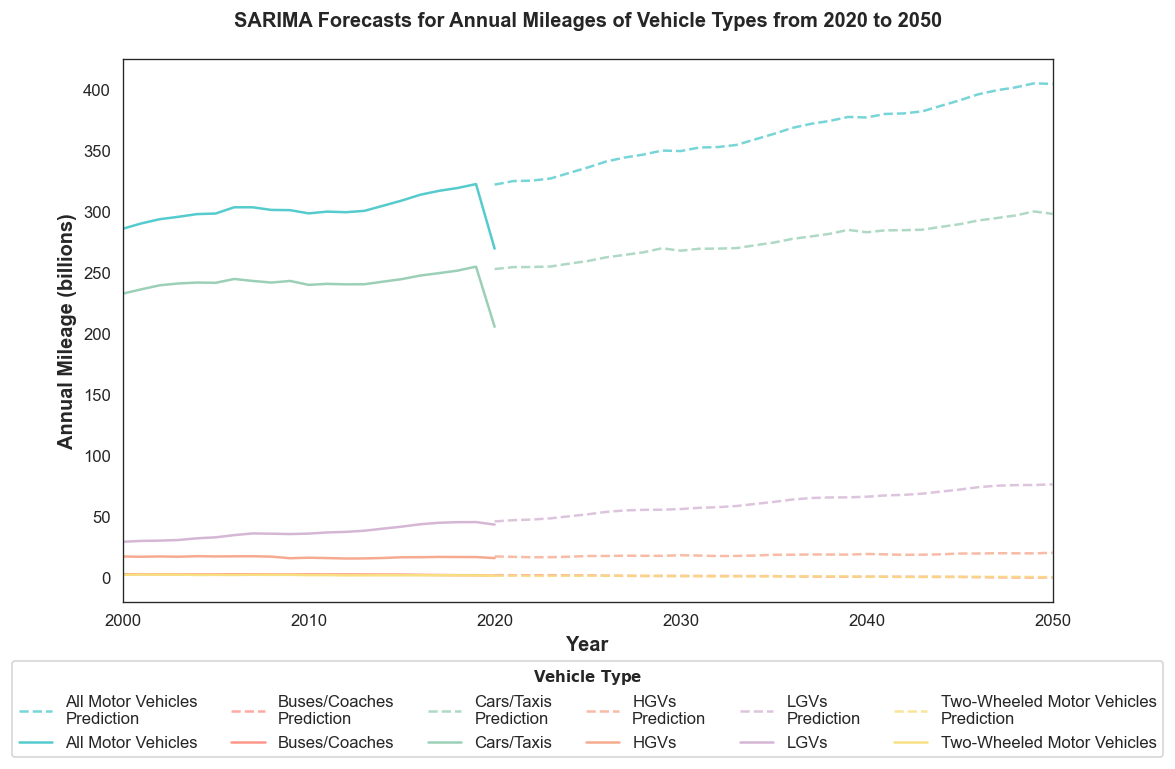

In [18]:
warnings.filterwarnings("ignore")

sns.set_style('white')
plt.figure(figsize=(10, 6), dpi=120)
for v_type in vehicle_types:
    series = vtm[vtm['vehicle_type'] == v_type][['year','annual_mileage (billions)']].set_index('year')
    series.index = pd.to_datetime(series.index, format='%Y')
    
    model=SARIMAX(series[:20],order=(1,1,0),seasonal_order=(0,1,0,10))
    model=model.fit(disp=0)
    
    pred=model.predict(start=20,end=50,typ='levels').rename(f'{v_type}\nPrediction')
    pred.plot(legend=True, color=colors[v_type], linestyle='--', alpha=0.8)
    series['annual_mileage (billions)'].plot(legend=True, color=colors[v_type], label=f'{v_type}')


plt.title('SARIMA Forecasts for Annual Mileages of Vehicle Types from 2020 to 2050\n',
         fontweight='bold', fontsize=12)
plt.xlabel('Year', fontweight='bold', fontsize=12)
plt.ylabel('Annual Mileage (billions)', fontweight='bold', fontsize=12)
plt.legend(bbox_to_anchor=(0.5, -0.3), title='$\\bf{Vehicle\ Type}$',
           title_fontsize=9, loc='lower center', ncol=6)
plt.show()

Upon inspection, the SARIMA model is able to forecast annual mileages much better than the ARIMA model. Note that the model fails to capture drops in annual mileage due to external factors which cannot be predicted such as pandemics. Other limitations the model faces include estimations from small samples of AADF counts for minor roads since it is not feasible to indivually measure AADF for every minor road in the UK.

### Estimating Expected Increase in UK Electric Vehicles
Research published data on:
- Electric Vehicle Registration History
- Electric Charging Point History
- Electric Vehicle Pricing
Consider external factors such as UK legislation banning sales of petrol/diesel cars from 2030, and hybrid vehicles from 2035.
- https://www.gocompare.com/motoring/electric-cars/electric-car-adoption-prediction/

In [19]:
charging_point_data = pd.read_excel('charging point data.xlsx')
df_cp = charging_point_data.dropna(how='any').reset_index().drop(columns=['index', 'Month']).set_index('Year')
df_cp.index = pd.to_datetime(df_cp.index.astype(int), format='%Y')

Available Charging Points in the UK from 2015 to 2022

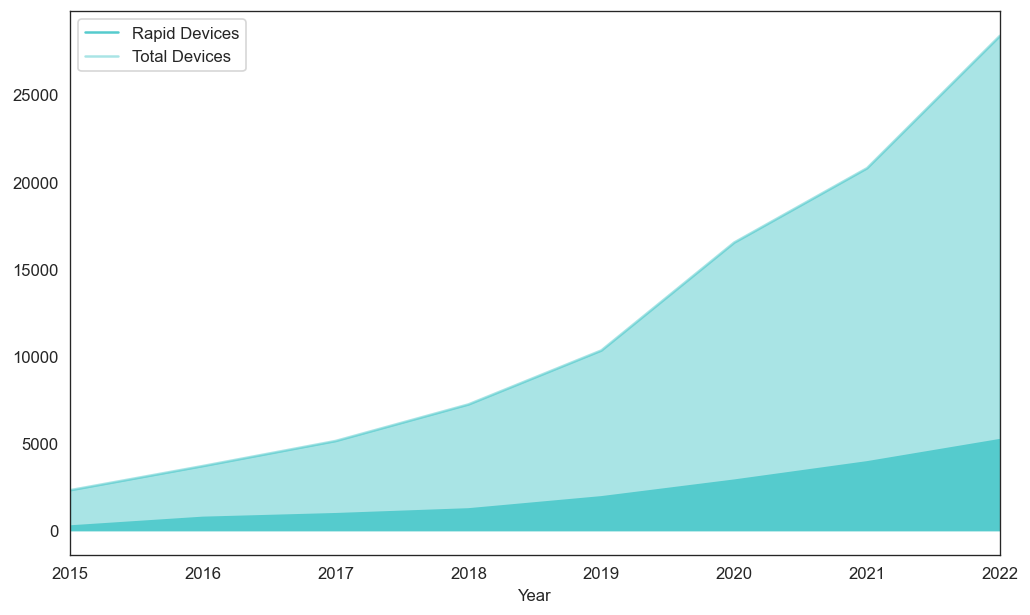

In [20]:
sns.set_style("white")
plt.figure(figsize=(10, 6), dpi=120)
df_cp['Rapid Devices'].plot(color='#55cbcd', legend=True)
df_cp['Total Devices'].plot(color='#55cbcd', alpha=0.5, legend=True)
plt.fill_between(df_cp.index, df_cp['Rapid Devices'], 0, zorder=2, color='#55cbcd')
plt.fill_between(df_cp.index, df_cp['Total Devices'], 0, zorder=1, color='#55cbcd', alpha=0.5)
plt.show()

In [21]:
df_ev = pd.DataFrame(data=None, columns=['Year', 'BEVs'])
df_ev['Year'] = list(range(2010, 2022))
df_ev['BEVs'] = [0, 0, 1262, 2512, 6697, 9934, 10264, 13597, 15510, 37850, 108205, 190727]
df_ev['PHEVs'] = [0, 0, 992, 1072, 7845, 18254, 26828, 33666, 42232, 34734, 66879, 114554]
df_ev['EVs'] = df_ev['BEVs'] + df_ev['PHEVs']
df_ev = df_ev.set_index('Year')
df_ev.index = pd.to_datetime(df_ev.index, format='%Y')

Registration of New Electric Vehicles in the UK from 2010 to 2021

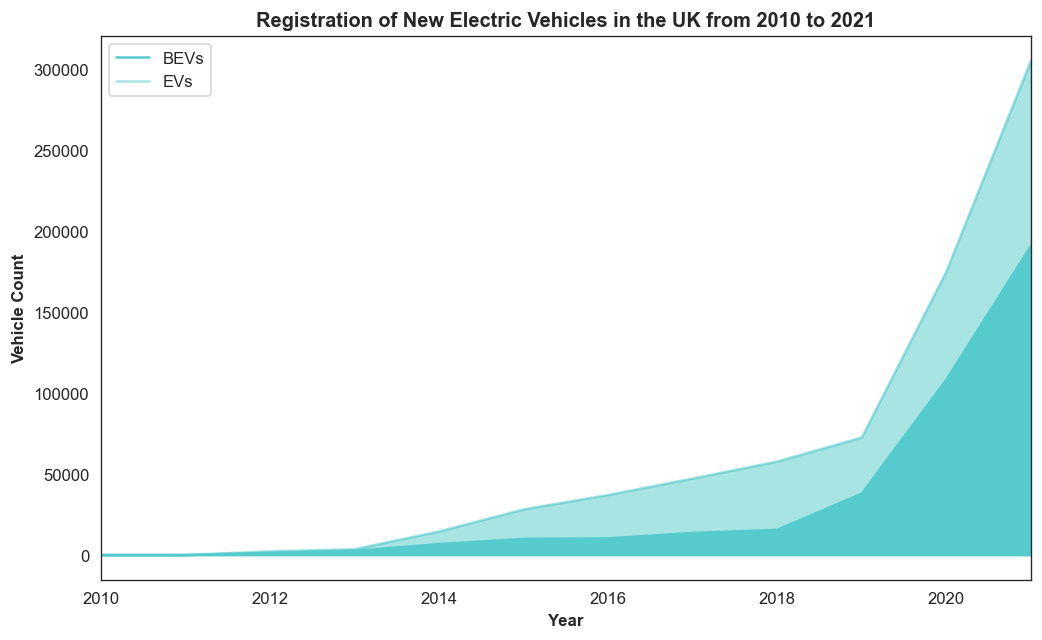

In [22]:
sns.set_style("white")
plt.figure(figsize=(10, 6), dpi=120)
df_ev['BEVs'].plot(color='#55cbcd', legend=True)
df_ev['EVs'].plot(color='#55cbcd', alpha=0.5, legend=True)
plt.fill_between(df_ev.index, df_ev['BEVs'], 0, zorder=2, color='#55cbcd')
plt.fill_between(df_ev.index, df_ev['EVs'], 0, zorder=1, color='#55cbcd', alpha=0.5)
plt.xlabel('Year', fontweight='bold')
plt.ylabel('Vehicle Count', fontweight='bold')
plt.title('Registration of New Electric Vehicles in the UK from 2010 to 2021', fontweight='bold')
plt.show()

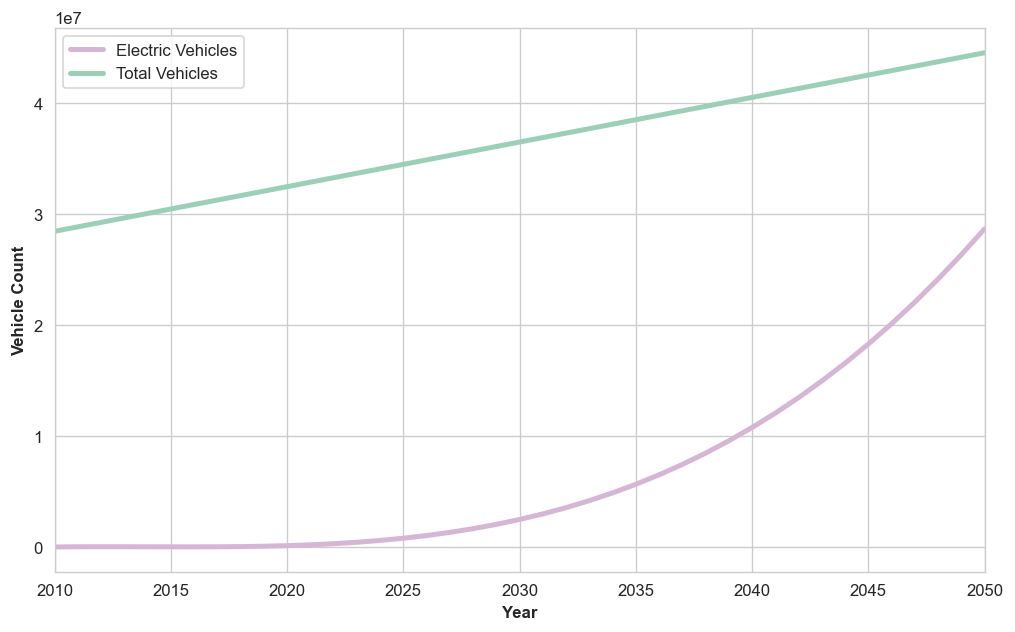

In [23]:
sns.set_style('whitegrid')
df_vcount = pd.read_excel('veh0202.xlsx').drop(columns=['Male', 'Female', 'Unknown', 'Company registered', 'Between keepers']) 
df_vcount = df_vcount.set_index('Year')
df_vcount['Total'] *= 1000

plt.figure(figsize=(10,6), dpi=120)

vcount_pred = np.poly1d(np.polyfit(np.arange(1994,2021), df_vcount['Total'], 1))
ev_pred = np.poly1d(np.polyfit(np.arange(2010,2022), df_ev['BEVs'], 3))

plt.plot(np.arange(2010, 2051), ev_pred(np.arange(2010, 2051)), color='#d5b6d5', label='Electric Vehicles', linewidth=3)
plt.plot(np.arange(2010, 2051), vcount_pred(np.arange(2010, 2051)), color='#9bd0b7', label='Total Vehicles', linewidth=3)
plt.xlabel('Year', fontweight='bold')
plt.ylabel('Vehicle Count', fontweight='bold')
plt.xlim(2010,2050)
plt.legend()
plt.show()

In [24]:
df_pred = pd.DataFrame()
df_pred['EV Predictions'] = ev_pred(np.arange(2020, 2051))
df_pred['Total Predictions'] = vcount_pred(np.arange(2020, 2051))
df_pred['Percentage'] = df_pred['EV Predictions']/df_pred['Total Predictions']

series = vtm[vtm['vehicle_type'] == 'All Motor Vehicles'][['year','annual_mileage (billions)']].set_index('year')
series.index = pd.to_datetime(series.index, format='%Y')

model=SARIMAX(series[:20],order=(1,1,0),seasonal_order=(0,1,0,10))
model=model.fit(disp=0)

pred=model.predict(start=20,end=50,typ='levels').rename(f'{v_type}\nPrediction')

df_pred['Total Mileage Predictions'] = pred.values[:]
df_pred['EV Mileage Predictions'] = df_pred['Percentage']*df_pred['Total Mileage Predictions']
df_pred.index = pd.to_datetime(np.arange(2020, 2051), format='%Y')

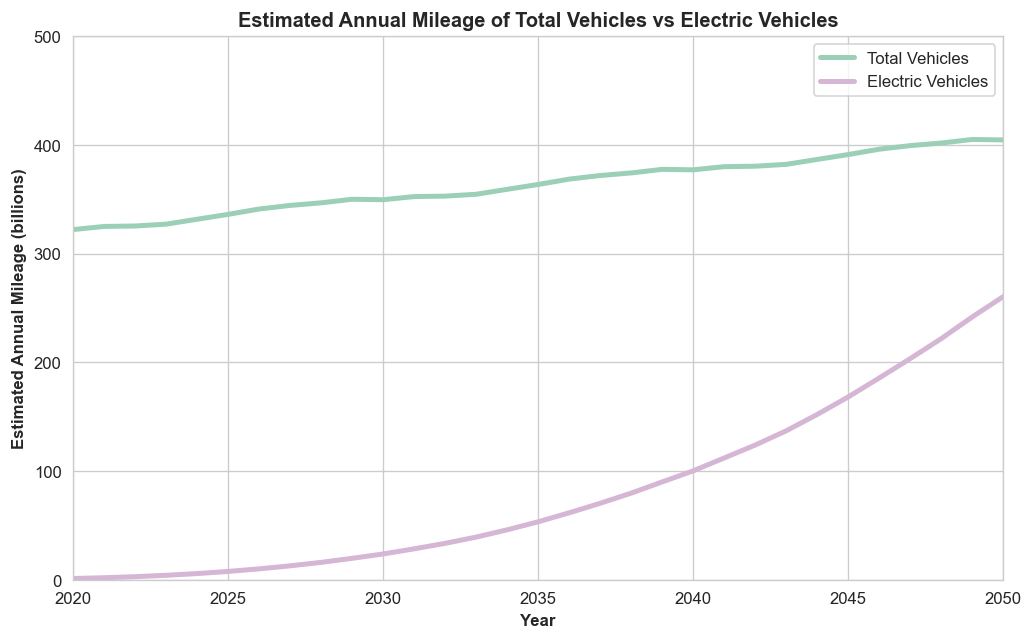

In [25]:
plt.figure(figsize=(10,6), dpi=120)
df_pred['Total Mileage Predictions'].plot(color='#9bd0b7', linewidth=3, label='Total Vehicles')
df_pred['EV Mileage Predictions'].plot(color='#d5b6d5', linewidth=3, label='Electric Vehicles')
plt.xlabel('Year', fontweight='bold')
plt.ylabel('Estimated Annual Mileage (billions)', fontweight='bold')
plt.title('Estimated Annual Mileage of Total Vehicles vs Electric Vehicles', fontweight='bold')
plt.ylim(0,500)
plt.legend()
plt.show()

### Estimating Additional Electricity Consumption due to Increase in Electric Vehicles

Average kWh/mile for New Electric Vehicles is approximately 0.3 kWh/mile.

In [26]:
df_pred['Electricity (TWh)'] = df_pred['EV Mileage Predictions']*0.3*10**12/10**12
df_pred.tail(10)

,EV Predictions,Total Predictions,Percentage,Total Mileage Predictions,EV Mileage Predictions,Electricity (TWh)
2041-01-01,1.204300e+07,4.087670e+07,0.294618,379.867329,111.915642,33.574693
2042-01-01,1.343866e+07,4.127864e+07,0.325560,380.283191,123.804838,37.141451
2043-01-01,1.493778e+07,4.168059e+07,0.358387,381.993568,136.901530,41.070459
2044-01-01,1.654405e+07,4.208253e+07,0.393134,386.536025,151.960262,45.588079
2045-01-01,1.826116e+07,4.248448e+07,0.429831,391.005587,168.066463,50.419939
2046-01-01,2.009279e+07,4.288642e+07,0.468512,395.929881,185.497752,55.649326
2047-01-01,2.204262e+07,4.328837e+07,0.509204,399.244970,203.297220,60.989166
2048-01-01,2.411434e+07,4.369031e+07,0.551938,401.613763,221.665865,66.499760
2049-01-01,2.631163e+07,4.409226e+07,0.596741,404.898634,241.619418,72.485825
2050-01-01,2.863819e+07,4.449420e+07,0.643639,404.481569,260.340005,78.102002


The transition to electric vehicles will increase demand for electricity. In September 2021, Ofgem, the energy regulator, highlighted that electric cars and vans will need between 60-100TWh of electricity annually by 2050 – an increase of 20-30% compared to 2021 levels.
- https://commonslibrary.parliament.uk/research-briefings/cbp-7480/

Expected Additional Electricity Consumption to Account for Increase in Electric Vehicles

Text(0.5, 1.0, 'Predicted Electricity Consumption of Electric Vehicles from 2020 to 2050')

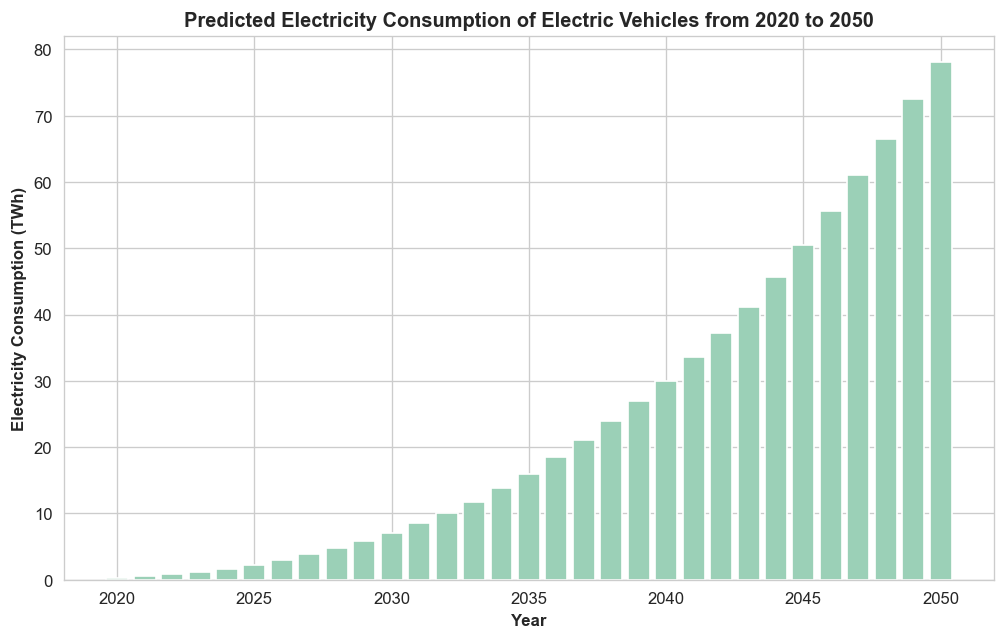

In [27]:
plt.figure(figsize=(10,6), dpi=120)
plt.bar(np.arange(2020, 2051), df_pred['Electricity (TWh)'], color='#9bd0b7')
plt.xlabel('Year', fontweight='bold')
plt.ylabel('Electricity Consumption (TWh)', fontweight='bold')
plt.title('Predicted Electricity Consumption of Electric Vehicles from 2020 to 2050', fontweight='bold')